In [26]:
import cv2
from matplotlib import pyplot as plt
import math
from skimage import io, color
from skimage.transform import resize
import numpy as np
import io

In [7]:
ip_img = cv2.imread('D:/train_tomato2/Tomato_Early_blight/image1.jpg',cv2.IMREAD_UNCHANGED)
[rows,cols]=ip_img.shape[0:2]
print(rows)
fixed_size=(400,400)
image = cv2.resize(ip_img, fixed_size) 

NameError: name 'cv2' is not defined

In [10]:
import os
os.sys.path

['',
 'C:\\Users\\moham\\Anaconda2\\python27.zip',
 'C:\\Users\\moham\\Anaconda2\\DLLs',
 'C:\\Users\\moham\\Anaconda2\\lib',
 'C:\\Users\\moham\\Anaconda2\\lib\\plat-win',
 'C:\\Users\\moham\\Anaconda2\\lib\\lib-tk',
 'C:\\Users\\moham\\Anaconda2',
 'C:\\Users\\moham\\Anaconda2\\lib\\site-packages',
 'C:\\Users\\moham\\Anaconda2\\lib\\site-packages\\win32',
 'C:\\Users\\moham\\Anaconda2\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\moham\\Anaconda2\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\moham\\Anaconda2\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\moham\\.ipython']

In [8]:
cv2.imshow('image',image)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [5]:
cv2.imshow('LAB image',lab_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
k = 100   # Number of Super pixels
m = 20    # Constant for normalizing the color proximity, range of m = [1,40]

img_h = lab_img.shape[0] # Image Height
img_w = lab_img.shape[1] # Image Width

N = img_h * img_w  # Total number of pixels in the image
S = int(math.sqrt(N /k)) # average size of each superpixel

In [4]:
lab_img = color.rgb2lab(image)

In [10]:
N


160000

In [11]:
S

40

In [27]:
clusters = []
tag = {}

# initialize the distance between pixels and cluster center as infinity
dis = np.full((img_h, img_w), np.inf)

In [28]:
dis.shape

(40L, 40L)

In [29]:
dis


array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [30]:
N

1600L

In [31]:
S

12

In [32]:
img_h

40L

In [33]:
lab_img[20,20][0]

NameError: name 'lab_img' is not defined

In [34]:
lab_img[20,20][1]

NameError: name 'lab_img' is not defined

In [35]:
lab_img[20,20][2]

NameError: name 'lab_img' is not defined

In [36]:
# function which returns an object of class SuperPixel
def make_superPixel(h, w,img):
    return(SuperPixels(h, w,img[h,w][0],img[h,w][1],img[h,w][2]))
    

In [37]:
# To define the initial cluster centers distanced at S
def initial_cluster_center(S,img,img_h,img_w,clusters):
    h = S // 2
    w = S // 2
    while h < img_h:
        while w < img_w:
            clusters.append(make_superPixel(h, w,img))
            w += S
        w = S // 2
        h += S
    return clusters

In [38]:
clusters

[]

In [39]:
# function to calculate gradient at each pixel 
def calc_gradient(h, w,img,img_w,img_h):
    if w + 1 >= img_w:
        w = img_w - 2
    if h + 1 >= img_h:
        h = img_h - 2
    grad = img[w + 1, h + 1][0] - img[w, h][0] + img[w + 1, h + 1][1] - img[w, h][1] + img[w + 1, h + 1][2] - img[w, h][2]
    return grad

In [40]:
# function which reassign the cluster center to the pixel having the lowest gradient
def reassign_cluster_center_acc_to_grad(clusters,img):
    for c in clusters:
        cluster_gradient = calc_gradient(c.h, c.w,img,img_w,img_h)
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                H = c.h + dh
                W = c.w + dw
                new_gradient = calc_gradient(H,W, img,img_w,img_h)
                if new_gradient < cluster_gradient:
                    c.update(H, W,img[H,W][0], img[H,W][1],img[H,W][2])
                    c_gradient = new_gradient

In [41]:
'''
function to assign pixels to the nearest cluster using the Euclidean distance involving both color and spatial
proximity.
'''
def assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis):
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):
            if h < 0 or h >= img_h: continue
            for w in range(c.w - 2 * S, c.w + 2 * S):
                if w < 0 or w >= img_w: continue
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds /S, 2))
                if D < dis[h,w]:
                    if (h, w) not in tag:
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        tag[(h, w)].pixels.remove((h, w))
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D

In [42]:
# function to replace the cluster center with the mean of the pixels contained in the cluster
def update_cluster_mean(clusters):
    for c in clusters:
        sum_h = sum_w = number = 0
        #print("c.pixels",c.pixels)
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
            H = sum_h // number
            W = sum_w // number
            c.update(H, W,img[H, W][0], img[H, W][1], img[H, W][2])

In [55]:
sum_h

NameError: name 'sum_h' is not defined

In [43]:
# replace the color of each pixel in a cluster by the color of the cluster's center
def avg_color_cluster(img,name,clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        # To change the color of cluster center to Black
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    lab2rgb(name, image)

In [44]:
# function for the Simple Linear Iterative Clustering
def slic(S,img,img_h,img_w,clusters,tag,dis):
    clusters = initial_cluster_center(S,img,img_h,img_w,clusters)
    reassign_cluster_center_acc_to_grad(clusters,img)
    for i in range(10): # usually the algortihm converges within 10 iterations
        assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis)
        update_cluster_mean(clusters)
        if i == 9 : # to print the output after 10 iterations
            name = 'out_m{m}_k{k}.png'.format(loop=i, m=m, k=k)
            avg_color_cluster(img,name, clusters)
    return clusters

In [45]:

# function to convert LAB images back to RGB and save it
def lab2rgb(path, lab_arr):
    rgb_arr = color.lab2rgb(lab_arr)
    cv2.imshow('RGB image',rgb_arr)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    io.imsave(path, rgb_arr)

In [46]:
# A class to initialize the super pixels, of the form - [h,y,l,a,b].
class SuperPixels(object):

    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)
        self.pixels = []

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

In [63]:
# read the input RGB image
rgb = cv2.imread("D:/Saiqa/chess.jpg")
print(rgb.shape)

# input images are resized to (400 x 400) for processing
# img = resize(rgb, (400,400))
# print(img.shape)

# convert RGB to LAB
img = color.rgb2lab(img)

k = 10  # Number of Super pixels
m = 20    # Constant for normalizing the color proximity, range of m = [1,40]

img_h = img.shape[0] # Image Height
img_w = img.shape[1] # Image Width

N = img_h * img_w  # Total number of pixels in the image
S = int(math.sqrt(N /k)) # average size of each superpixel

clusters = []
tag = {}
# initialize the distance between pixels and cluster center as infinity
dis = np.full((img_h, img_w), np.inf)

(256L, 256L, 3L)


In [66]:
 cluster = slic(S,img,img_h,img_w,clusters,tag,dis)



AttributeError: 'module' object has no attribute 'imsave'

In [58]:
def slic(S,img,img_h,img_w,clusters,tag,dis):
    clusters = initial_cluster_center(S,img,img_h,img_w,clusters)
    reassign_cluster_center_acc_to_grad(clusters,img)
    for i in range(10): # usually the algortihm converges within 10 iterations
        assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis)
        update_cluster_mean(clusters)
        if i == 9 : # to print the output after 10 iterations
            name = 'out_m_k.jpg'.format(loop=i, m=m, k=k)
            avg_color_cluster(img,name, clusters)
    return clusters

In [59]:
clusters

[]

In [54]:
# superpixels
for c in clusters:
    print("H {} : W {}, l {}, a {}, b {}".format(c.h,c.w,c.l,c.a,c.b))

H 14 : W 14, l 0.0, a 0.0, b 0.0
H 14 : W 42, l 0.0, a 0.0, b 0.0
H 14 : W 70, l 0.0, a 0.0, b 0.0
H 14 : W 98, l 0.0, a 0.0, b 0.0
H 14 : W 126, l 0.0, a 0.0, b 0.0
H 13 : W 157, l 0.0, a 0.0, b 0.0
H 48 : W 185, l 170.769606119, a -150.65786591, b 153.534878884
H 30 : W 193, l 49.9114211652, a -67.6773059443, b 199.841583754
H 13 : W 227, l 0.0, a 0.0, b 0.0
H 12 : W 265, l 0.0, a 0.0, b 0.0
H 13 : W 294, l 0.0, a 0.0, b 0.0
H 14 : W 322, l 0.0, a 0.0, b 0.0
H 14 : W 350, l 0.0, a 0.0, b 0.0
H 14 : W 382, l 0.0, a 0.0, b 0.0
H 42 : W 14, l 0.0, a 0.0, b 0.0
H 42 : W 42, l 0.0, a 0.0, b 0.0
H 42 : W 70, l 0.0, a 0.0, b 0.0
H 42 : W 98, l 0.0, a 0.0, b 0.0
H 42 : W 126, l 0.0, a 0.0, b 0.0
H 41 : W 159, l 0.0, a 0.0, b 0.0
H 47 : W 188, l 162.804549612, a -139.316335659, b 157.038921572
H 61 : W 202, l 880.62886975, a 1037.94881883, b 872.812695787
H 44 : W 234, l 0.0, a 0.0, b 0.0
H 39 : W 265, l 0.0, a 0.0, b 0.0
H 39 : W 293, l 0.0, a 0.0, b 0.0
H 42 : W 322, l 0.0, a 0.0, b 0.0
H 4

In [87]:
cv2.imshow('out_m_k.jpg')

TypeError: Required argument 'mat' (pos 2) not found

In [88]:
from skimage import segmentation, color
from skimage.io import imread
from skimage.future import graph
from matplotlib import pyplot as plt
img = imread('D:/train_tomato2/Tomato_Early_blight/image1.jpg')

img_segments = segmentation.slic(img, compactness=20, n_segments=500)
superpixels = color.label2rgb(img_segments, img, kind='avg')

In [90]:
cv2.imshow()

TypeError: Required argument 'mat' (pos 2) not found

<IPython.core.display.Javascript object>


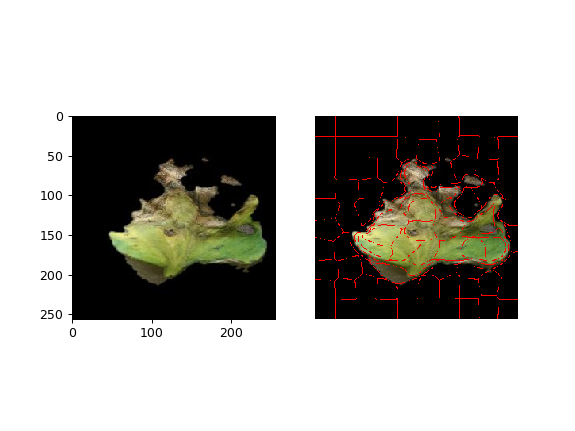

In [15]:
%matplotlib notebook
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
 
image = cv2.imread('D:/train_tomato4/Tomato_early_blight/5.jpg')
height,width=image.shape[:2]
# ret, bw_img = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
segments = slic(image, n_segments = 100, sigma = 5) 
# ax = fig.add_subplot(1, 1, 1)
a=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(a)
plt.subplot(122),plt.imshow(mark_boundaries(img_as_float(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)),segments,color=[255,0,0],mode='subpixel'))
# ax.imshow()
plt.axis("off")
plt.show()

In [2]:
height,width

(256L, 256L)

(<matplotlib.axes._subplots.AxesSubplot at 0xbddae80>,
 Text(0.5,1,'LAB_IMAGE'))

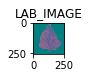

In [3]:
lab_image = cv2.cvtColor(a, cv2.COLOR_BGR2LAB)
plt.subplot(664),plt.imshow(lab_image),plt.title('LAB_IMAGE')

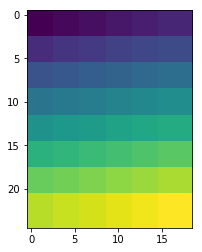

In [50]:
plt.imshow(segments)

('j', 0)
(0, 0)
1
(0, 1)
2
(0, 2)
3
('j is now', 0)
('j', 1)
(1, 0)
1
(1, 1)
2
(1, 2)
3
('j is now', 1)
('j', 2)
(2, 0)
1
(2, 1)
2
(2, 2)
3
('j is now', 2)
('j', 3)
('j is now', 3)
('j', 4)
('j is now', 4)
('j', 5)
('j is now', 5)
('j', 6)
('j is now', 6)
('j', 7)
('j is now', 7)
('j', 8)
('j is now', 8)
('j', 9)
('j is now', 9)
('j', 10)
('j is now', 10)
('j', 11)
('j is now', 11)
('j', 12)
('j is now', 12)
('j', 13)
('j is now', 13)
('j', 14)
('j is now', 14)
('j', 15)
('j is now', 15)
('j', 16)
('j is now', 16)
('j', 17)
('j is now', 17)
('j', 18)
('j is now', 18)
('j', 19)
('j is now', 19)
('j', 20)
('j is now', 20)
('j', 21)
('j is now', 21)
('j', 22)
('j is now', 22)
('j', 23)
('j is now', 23)
('j', 24)
('j is now', 24)
('Final column of superpixel cluster', [3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('Superpixel segment', [array([255, 128, 128], dtype=uint8), array([253, 128, 128], dtype=uint8), array([255, 128, 128], dtype=uint8), array([254, 1

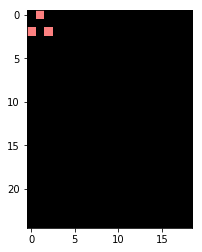

In [78]:

count=[]
flag=0
from statistics import mean
d1_a=d1_b=d2_a=d2_b=[]
for i in range(0,1,1):
    arr=[]
    coordinate=[]
    for j in range(height): 
        print('j',j)
        counter=0
        for k in range(width):   
                if segments[j,k]==i: 
#                     print(j,k)
                    coordinate.append([j,k])
                    print(j,k)
                    arr.append(lab_image[j,k])  
                    counter=counter+1
                    print(counter)
        print('j is now',j)
        count.append(counter)            
    print('Final column of superpixel cluster',count)   
    # row=j-init_j
    # col=k-init_k
    # print('Number of rows and columns of a cluster',row,col)
    # print('Final rows and columns',j,k)
    print('Superpixel segment',arr)
    min_l=min([x[0] for x in arr])
    min_a=min([x[1] for x in arr])
    min_b=min([x[2] for x in arr])
    print(min_l,min_a,min_b)
    max_l=max([x[0] for x in arr])
    max_a=max([x[1] for x in arr])
    max_b=max([x[2] for x in arr])
    print(max_l,max_a,max_b)
    arr = np.asarray(arr)
#     vectorized=arr.reshape(-1,3)
    vectorized=np.float32(arr)
    criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10, 1.0)
    k=2
    init_center=([min_l, min_a,  min_b], [max_l, max_a,  max_b])
    res1,label,center=cv2.kmeans(vectorized,k,np.array(init_center), criteria,10,cv2.KMEANS_RANDOM_CENTERS)
#     center=np.uint8(center)
#     c=(label.flatten())
    res2 = center[c.astype(int)]
    res3= res2.reshape((3,-1,3))
#                 # c=(label==0).flatten()
    reshape_label=label.reshape(-1,3)
#     plt.subplot(131),plt.imshow(reshape_label,cmap='gray')
    # plt.subplots_adjust(bottom=1.0, right=1.8, top=3.0, wspace = 0.5, hspace=0.5)
#     plt.subplot(132),plt.imshow(res3)
    # #             plt.hist(reshape_label.ravel(),4,[0,4]); plt.show()
#     plt.subplot(133),plt.imshow(arr)
    h,w=reshape_label.shape[:2]
    print('height,width of superpixel',h,w)
    for i in range(h):
        for j in range(w):
    #         print('i &j',i,'+',j)
    #         print(reshape_label[i,j])
            if reshape_label[i,j]==1:
    #             print('in if',reshape_label[i,j])
                d1_a.append(res3[i,j,1])
                d1_b.append(res3[i,j,2])
    #             print('values',d1_a[counter])
    #             print('values',d1_b[counter])
            else:
                d2_a.append(res3[i,j,1])
                d2_b.append(res3[i,j,2])
    #             print('values',d2_a[counter])
    #             print('values',d2_b[counter])
    #         counter=counter+1

    print(np.mean(d1_a))
    print(np.mean(d1_b))
    print(np.mean(d2_a))
    print(np.mean(d2_b))
    labels = list(label.reshape(1, -1)[0])
    lab_image = np.zeros_like(lab_image)
    for idx, value in enumerate(labels):
        if value == 0:
            print(value)
            x, y = coordinate[idx]
            print(x,y)
            print('arr[idx]',arr[idx])
            lab_image[x,y]=arr[idx]
            print('lab_image',lab_image[x,y])
    
    plt.imshow(lab_image)
#     if d1_a<= d2_a and d1_b <=d2_b:
#        print(label.index('0'))


In [86]:
res3.shape

(3L, 3L, 3L)

In [87]:
arr.shape

(9L, 3L)

In [82]:
res2

array([[254, 128, 128],
       [252, 128, 128],
       [254, 128, 128],
       [254, 128, 128],
       [254, 128, 128],
       [254, 128, 128],
       [252, 128, 128],
       [254, 128, 128],
       [252, 128, 128]], dtype=uint8)

In [83]:
res3

array([[[254, 128, 128],
        [252, 128, 128],
        [254, 128, 128]],

       [[254, 128, 128],
        [254, 128, 128],
        [254, 128, 128]],

       [[252, 128, 128],
        [254, 128, 128],
        [252, 128, 128]]], dtype=uint8)

In [73]:
print(lab_image[:3, :3])

[[[255 128 128]
  [253 128 128]
  [255 128 128]]

 [[254 128 128]
  [255 128 128]
  [255 128 128]]

 [[253 128 128]
  [255 128 128]
  [252 128 128]]]


In [77]:
lab_image[:3,:3]

array([[[255, 128, 128],
        [253, 128, 128],
        [255, 128, 128]],

       [[254, 128, 128],
        [255, 128, 128],
        [255, 128, 128]],

       [[253, 128, 128],
        [255, 128, 128],
        [252, 128, 128]]], dtype=uint8)

In [67]:
segments

array([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,
         5,  5,  5],
       [ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,
         5,  5,  5],
       [ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,
         5,  5,  5],
       [ 6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
        11, 11, 11],
       [ 6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
        11, 11, 11],
       [ 6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
        11, 11, 11],
       [12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17,
        17, 17, 17],
       [12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17,
        17, 17, 17],
       [12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17,
        17, 17, 17],
       [18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23,
        23, 23, 23],
       [18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23

In [22]:
labels

[0, 0, 0, 0, 0, 0, 0, 0, 1]

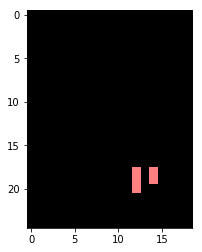

In [15]:
empty_arr

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [121]:
x = [5,1,7,0,3,4,5,3,2,6,7,3,6]
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
print(get_indexes(7,x))


[2, 10]


In [136]:
indexes = [i for i,x in enumerate(label) if x == 0]
for i in range(len(indexes))
     arr[coordinate[indexes]]=0

[1, 2, 3, 4, 7, 8]

In [138]:

coordinate[2]
arr[indexes]

[18, 11]

In [128]:
label=label.flatten()
print(label)
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
print(get_indexes(0,x))

[1 0 0 0 0 1 1 0 0]
[3]


In [127]:
label

array([1, 0, 0, 0, 0, 1, 1, 0, 0])

In [359]:
segments

array([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,
         5,  5,  5],
       [ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,
         5,  5,  5],
       [ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,
         5,  5,  5],
       [ 6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
        11, 11, 11],
       [ 6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
        11, 11, 11],
       [ 6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
        11, 11, 11],
       [12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17,
        17, 17, 17],
       [12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17,
        17, 17, 17],
       [12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17,
        17, 17, 17],
       [18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23,
        23, 23, 23],
       [18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23

In [347]:
res3.shape

(3L, 4L, 3L)

In [349]:
reshape_label.shape

(4L, 3L)

In [345]:
# res2=res2.reshape(3,3,3)
res2

array([[255, 128, 128],
       [255, 128, 128],
       [255, 128, 128],
       [253, 128, 128],
       [253, 128, 128],
       [253, 128, 128],
       [255, 128, 128],
       [255, 128, 128],
       [253, 128, 128],
       [255, 128, 128],
       [255, 128, 128],
       [255, 128, 128]], dtype=uint8)

In [100]:
from statistics import mean
d1_a=[]
d1_b=[]
d2_a=[]
d2_b=[]
h,w=reshape_label.shape[:2]
print('height,width of superpixel',h,w)
for i in range(h):
    for j in range(w):
#         print('i &j',i,'+',j)
#         print(reshape_label[i,j])
        if reshape_label[i,j]==1:
#             print('in if',reshape_label[i,j])
            d1_a.append(res3[i,j,1])
            d1_b.append(res3[i,j,2])
#             print('values',d1_a[counter])
#             print('values',d1_b[counter])
        else:
            d2_a.append(res3[i,j,1])
            d2_b.append(res3[i,j,2])
#             print('values',d2_a[counter])
#             print('values',d2_b[counter])
#         counter=counter+1

print(np.mean(d1_a))
print(np.mean(d1_b))
print(np.mean(d2_a))
print(np.mean(d2_b))
if d1_a<= d2_a and d1_b <=d2_b:
    

('height,width of superpixel', 3L, 3L)
('in if', 1)
('in if', 1)
('in if', 1)
128.0
128.0
128.0
128.0


In [89]:
reshape_label.shape

(3L, 1L, 3L)

In [90]:
reshape_label

array([[[0, 1, 1]],

       [[1, 1, 0]],

       [[0, 1, 1]]])

In [299]:
d2_a

[128, 128, 128]

In [284]:
a=[]
# a[1]=(res2[0,0,1])
a.append(res2[0,0,1])

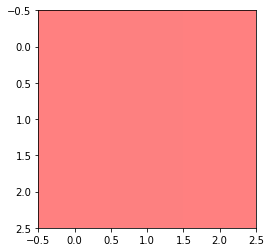

In [232]:
res2=res2.reshape(3,3,3)
plt.imshow(res2)

In [124]:
len(a)

2

In [92]:
x=[]
lab_image[0,0]
i=0
for record in lab_image: 
    x.append(record)
    

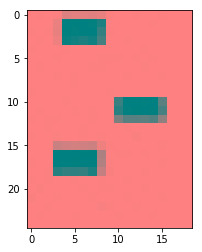

In [94]:
plt.imshow(x)

In [77]:
lab_image.ndim


3

In [79]:
import cv2
import numpy as np

a = np.zeros((100, 100,3))
a[:,:,0] = 255

b = np.zeros((100, 100,3))
b[:,:,1] = 255

c = np.zeros((100, 200,3)) 
c[:,:,2] = 255

img = np.vstack((c, np.hstack((a, b))))

cv2.imshow('image', img)
cv2.waitKey(0)

27

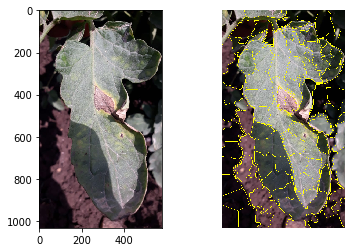

In [161]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
 
image = cv2.imread('D:/praneet_trained/Pune/Early_blight/1.jpg')
# ret, bw_img = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
segments = slic(image, n_segments = 100, sigma = 5) 
# ax = fig.add_subplot(1, 1, 1)
a=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(a)
plt.subplot(122),plt.imshow(mark_boundaries(img_as_float(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)),segments,color=[25,10,0]))
# ax.imshow()
plt.axis("off")
plt.show()

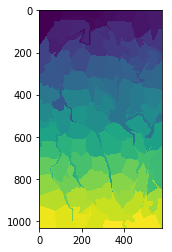

In [15]:
plt.imshow(segments)

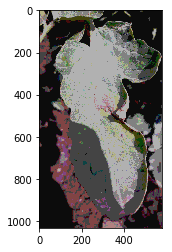

In [162]:
            vectorized=a.reshape(-1,1)
            vectorized=np.float32(vectorized)
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10, 1.0)
            k=4
            res1,label,center=cv2.kmeans(vectorized,k,None, criteria,10,cv2.KMEANS_RANDOM_CENTERS)
            center=np.uint8(center)
            c=(label.flatten())
            res2 = center[c.astype(int)]
            res3= res2.reshape((a.shape))
            # c=(label==0).flatten()
            reshape_label=label.reshape(1032,581,3)
#             plt.subplot(111),plt.imshow(reshape_label,cmap='gray')
            plt.imshow(res3)   
#             plt.hist(reshape_label.ravel(),4,[0,4]); plt.show()

In [164]:
a.shape

(1032L, 581L, 3L)

In [175]:
vectorized.shape

(1425L, 1L)

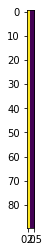

In [159]:
            vectorized=a.reshape(-1,1)
            vectorized=np.float32(vectorized)
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10, 1.0)
            k=2
#             init_center=([105, 112,  79], [110, 117,  83], [122, 126,  91],[0,0,0])
            res1,label,center=cv2.kmeans(vectorized,k,None, criteria,10,cv2.KMEANS_RANDOM_CENTERS)
            center=np.uint8(center)
            c=(label.flatten())
            res2 = center[c.astype(int)]
            res3= res2.reshape((a.shape))
            # c=(label==0).flatten()
#             reshape_label=label.reshape(1032,581,3)
#             plt.subplot(111),plt.imshow(reshape_label,cmap='gray')
            plt.imshow(res3)
#             plt.hist(reshape_label.ravel(),4,[0,4]); plt.show()

In [166]:
vectorized.shape

(1798776L, 1L)

In [23]:
cv2.imshow('image',res3)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [40]:
reshape_label

array([[[0, 0, 3],
        [0, 0, 3],
        [0, 0, 3],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[0, 0, 3],
        [0, 0, 3],
        [0, 0, 3],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       ...,

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [3, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]])

In [39]:
cv2.imshow('Reshape',reshape_label)

error: OpenCV(4.1.1) C:/projects/opencv-python/opencv/modules/highgui/src/precomp.hpp:131: error: (-215:Assertion failed) src_depth != CV_16F && src_depth != CV_32S in function 'convertToShow'


In [26]:
c.shape

(1798776L,)

In [84]:
image.shape

(1032L, 581L, 3L)